In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as oj
import math
import pygsheets
import pickle as pkl
import pandas as pd
import load_data
import seaborn as sns
sys.path.append('modeling')
from viz import viz, viz_interactive
from exponential_modeling import estimate_deaths
from fit_and_predict import fit_and_predict

outcomes = ['tot_cases', 'tot_deaths']
df_hospital = load_data.load_hospital_level()
df_county = load_data.load_county_level()
df_county = df_county.sort_values('tot_deaths', ascending=False)
NUM_DAYS_LIST = [1, 2, 3]
# df_county = exponential_modeling.estimate_deaths(df_county) # adds key 
for num_days_in_future in NUM_DAYS_LIST: # 1 is tomorrow
    output_key = f'Predicted Deaths {num_days_in_future}-day'    
    df_county = fit_and_predict(df_county, 
                                method='ensemble', 
                                outcome='deaths',
                                mode='predict_future',
                                target_day=np.array([num_days_in_future]),
                                output_key=output_key
                               )
    
    # extract out vals from list
    vals = df_county[output_key].values
    out = []
    for i in range(vals.shape[0]):
        if np.isnan(vals[i]):
            out.append(0)
        else:
            out.append(vals[i][0])
    df_county[output_key] = out
df = df_hospital.merge(df_county, how='left', on='countyFIPS')
df[outcomes] = df[outcomes].fillna(0)

# aggregate employees by county
total_emp_county = df.groupby('countyFIPS').agg({'Hospital Employees': 'sum'})
total_emp_county = total_emp_county.rename(columns={'Hospital Employees': 'Hospital Employees in County'})
df_county = pd.merge(df_county, total_emp_county, how='left', on='countyFIPS')
df = pd.merge(df, total_emp_county, how='left', on='countyFIPS')

# filter hospitals
df = df[~df['countyFIPS'].isna()] # & df['IsAcademicHospital'] & df['Hospital Employees'] > 0]
df = df.sort_values(by=['tot_deaths', 'Hospital Employees'], ascending=False)


# fraction of employees out of all county hospitals
df['Frac Hospital Employees of County'] = df['Hospital Employees'] / df['Hospital Employees in County']

In [24]:
# this is number of new predicted deaths
for num_days in NUM_DAYS_LIST:
    df[f'Predicted Deaths Hospital {num_days}-day'] = ((df[f'Predicted Deaths {num_days}-day'] - df['tot_deaths']) * df['Frac Hospital Employees of County']).fillna(0)
    df[f'Severity {num_days}-day'] = pd.qcut(df[f'Predicted Deaths Hospital {num_days}-day'], 5, labels=False) + 1
#     df[f'Quantile {num_days}-day'] = 
k = 2
sk = f'Predicted Deaths Hospital {k}-day'
df = df.sort_values(sk, ascending=False).round(2)

In [19]:
df.head(5)

,Unnamed: 0,CMS Certification Number,Facility Name,Street Address_x,City_x,State_x,ZIP,System Affiliation,Type of Facility,Hospital Employees,...,Predicted Deaths 2-day,Predicted Deaths 3-day,Hospital Employees in County,Frac Hospital Employees of County,Predicted Deaths Hospital 1-day,Severity 1-day,Predicted Deaths Hospital 2-day,Severity 2-day,Predicted Deaths Hospital 3-day,Severity 3-day
6004,6004,503300,Seattle Children's Hospital & Regional Medical...,4800 Sand Point Way Northeast,Seattle,WA,98105,"Not In Any System - ,",Childrens,5478.0,...,181.23,197.59,40213.0,0.14,22.66,5.0,24.69,5.0,26.92,5.0
4692,4692,390180,Crozer-Chester Medical Center,One Medical Center Boulevard,Upland,PA,19013,"Prospect Medical Holdings - Los Angeles, CA",Short Term Acute Care,2636.0,...,6.05,7.17,6283.0,0.42,2.11,5.0,2.54,5.0,3.01,5.0
4388,4388,370028,INTEGRIS Baptist Medical Center,3300 Northwest Expressway,Oklahoma City,OK,73112,"INTEGRIS Health - Oklahoma City, OK",Short Term Acute Care,2983.0,...,6.94,8.66,19043.0,0.16,0.86,5.0,1.09,5.0,1.36,4.0
2192,2192,180040,UofL Health - Jewish Hospital,200 Abraham Flexner Way,Louisville,KY,40202,"UofL Health - Louisville, KY",Short Term Acute Care,3501.0,...,5.53,6.42,17185.0,0.20,0.96,5.0,1.13,5.0,1.31,4.0
5934,5934,500054,Providence Sacred Heart Medical Center and Chi...,101 West Eighth Avenue,Spokane,WA,99204,"Providence St. Joseph Health - Renton, WA",Short Term Acute Care,3515.0,...,8.92,12.61,7630.0,0.46,2.89,5.0,4.11,5.0,5.81,5.0


**look at distribution of predicted deaths at hospitals**

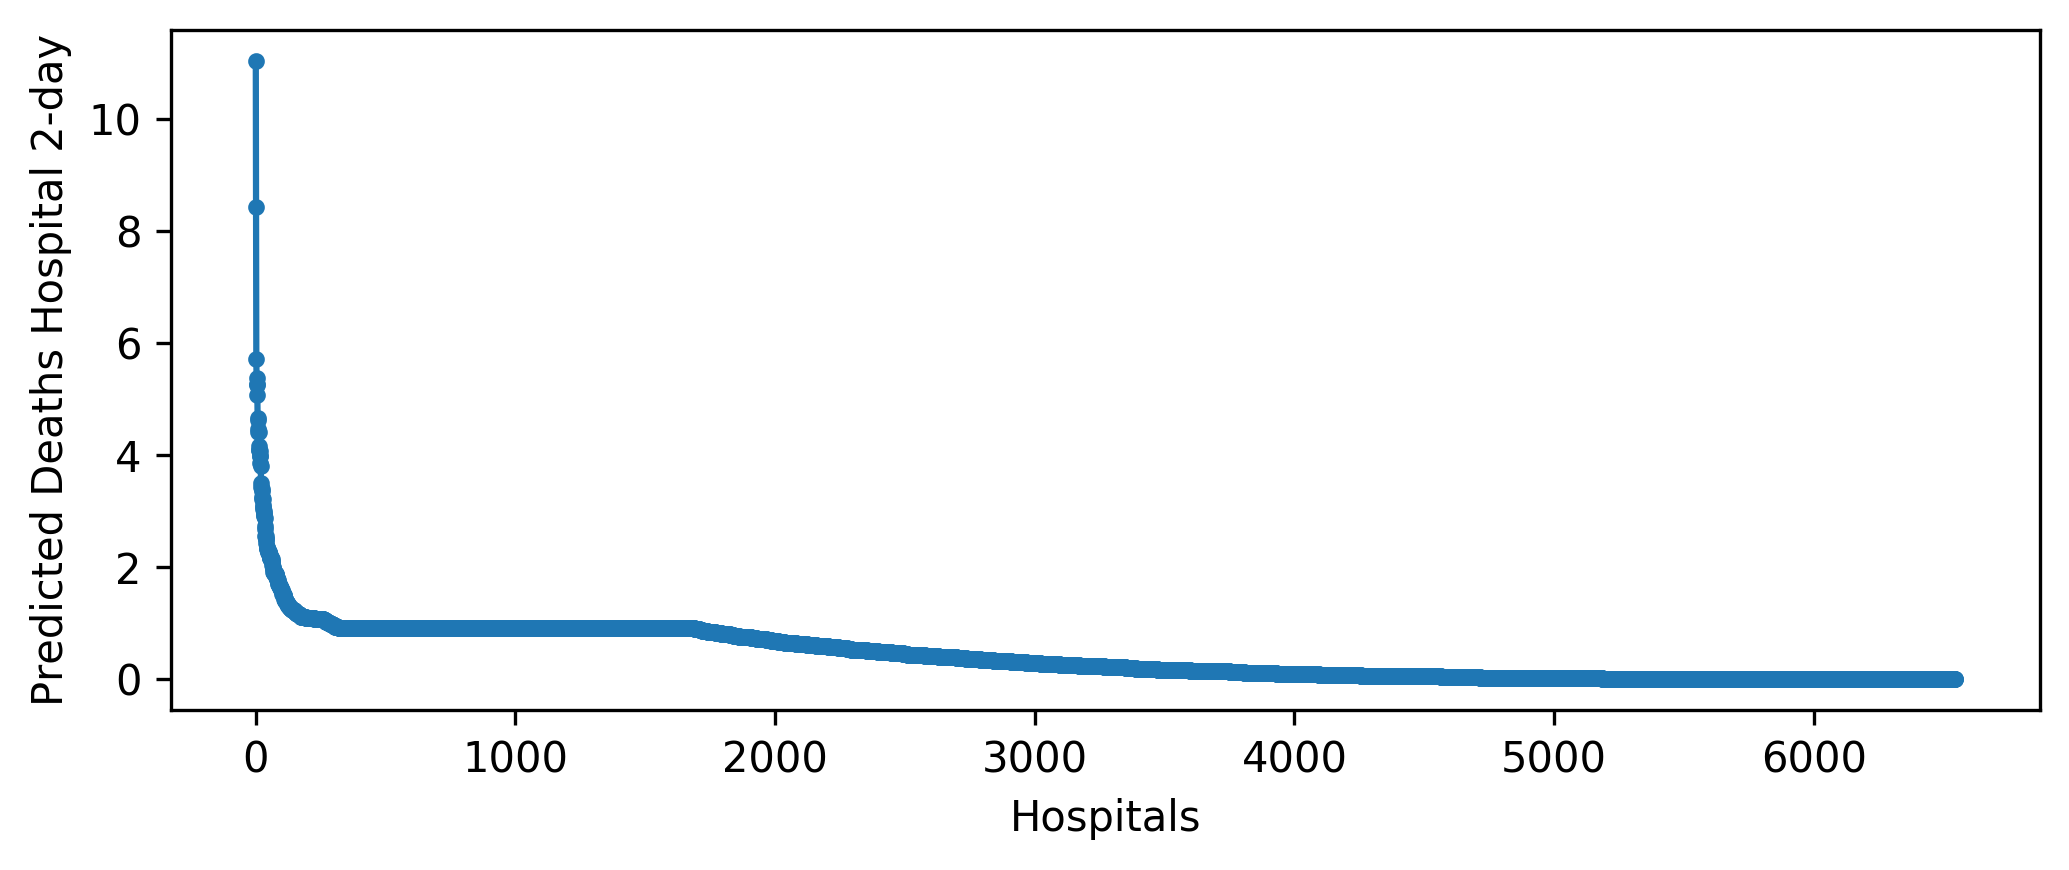

In [34]:
R, C  = 1, 1
num_days = 1
nonzero = df[f'Predicted Deaths {num_days}-day'] > 0
plt.figure(dpi=300, figsize=(7, 3))
plt.subplot(R, C, 1)
# plt.hist(df[f'Predicted Deaths Hospital {num_days}-day'][nonzero])
# plt.yscale('log')
# plt.xlabel('Predicted COVID19 Deaths\n(When greater than zero)')
# plt.ylabel('Num Hospitals')

plt.plot(df[sk].values, '.-')
plt.ylabel(sk)
plt.xlabel('Hospitals')

'''
plt.subplot(R, C, 2)
# plt.yscale('log')
plt.ylabel('Num Hospitals')
'''
plt.tight_layout()
plt.show()

In [14]:
df.sort_values('Predicted Deaths Hospital 2-day', ascending=False)[['Hospital Name', 'State_x', 
                                                                    'Hospital Employees', 'tot_deaths',
                                                                    'Predicted Deaths Hospital 2-day']].head(30)

,Hospital Name,Hospital Name,State_x,State_x,Hospital Employees,tot_deaths,Predicted Deaths Hospital 2-day
2735,Henry Ford Hospital,Henry Ford Hospital,MI,MI,11178.0,83.0,35.11
2769,"Beaumont Hospital, Royal Oak",William Beaumont Hospital - Royal Oa,MI,MI,8754.0,59.0,27.90
6004,Seattle Children's Hospital & Regional Medical...,Seattle Childrens Hospital,WA,WA,5478.0,152.0,25.37
5914,Providence Regional Medical Center Everett Col...,Prov Regl Med Center Everett,WA,WA,3128.0,30.0,23.06
3548,Hackensack University Medical Center,Hackensack University Medical Center,NJ,NJ,6489.0,41.0,22.26
5910,Virginia Mason Hospital and Seattle Medical Ce...,Virginia Mason Medical Center,WA,WA,4723.0,152.0,21.75
1255,Phoebe Putney Memorial Hospital,Phoebe Putney Memorial Hospital,GA,GA,2151.0,18.0,21.48
3807,Long Island Jewish Medical Center,Long Island Jewish Medical Center,NY,NY,14275.0,48.0,20.13
5922,Swedish First Hill Campus,Swedish Medical Center,WA,WA,4365.0,152.0,19.94
5912,University of Washington Medical Center-Montlake,University Of Washington Med Ctr,WA,WA,4343.0,152.0,19.94


# adjustments

**different measures of hospital size are pretty consistent**

In [ ]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 3
plt.subplot(R, C, 1)
plt.plot(df['Hospital Employees'], df['Total Average Daily Census'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Average Daily Census')

plt.subplot(R, C, 2)
plt.plot(df['Hospital Employees'], df['Total Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Beds')

plt.subplot(R, C, 3)
plt.plot(df['Hospital Employees'], df['ICU Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('ICU Beds')

plt.tight_layout()
plt.show()

**other measures are harder to parse...**

In [ ]:
plt.figure(dpi=300, figsize=(4, 3))
R, C = 1, 1

plt.subplot(R, C, 1)
plt.plot(df['Hospital Employees'], df['Total Occupancy Rate'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('ICU Occupancy Rate')

'''
plt.subplot(R, C, 2)
# plt.plot(df['Hospital Employees'], df[], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('ICU Occupancy Rate')
'''

plt.tight_layout()
plt.show()

**different hospital types**

In [ ]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 3
a = 0.5
plt.subplot(R, C, 1)
idxs = df.IsUrbanHospital == 1
plt.hist(df[idxs]['Hospital Employees'], label='Urban', alpha=a)
plt.hist(df[~idxs]['Hospital Employees'], label='Rural', alpha=a)
plt.ylabel('Num Hospitals')
plt.xlabel('Num Hospital Employees')
plt.legend()

plt.subplot(R, C, 2)
idxs = df.IsAcuteCareHospital == 1
plt.hist(df[idxs]['Hospital Employees'], label='Acute Care', alpha=a)
plt.hist(df[~idxs]['Hospital Employees'], label='Other', alpha=a)
plt.xlabel('Num Hospital Employees')
plt.legend()

plt.subplot(R, C, 3)
idxs = df.IsAcademicHospital == 1
plt.hist(df[idxs]['Hospital Employees'], label='Academic', alpha=a)
plt.hist(df[~idxs]['Hospital Employees'], label='Other', alpha=a)
plt.xlabel('Num Hospital Employees')

plt.legend()
plt.tight_layout()
plt.show()


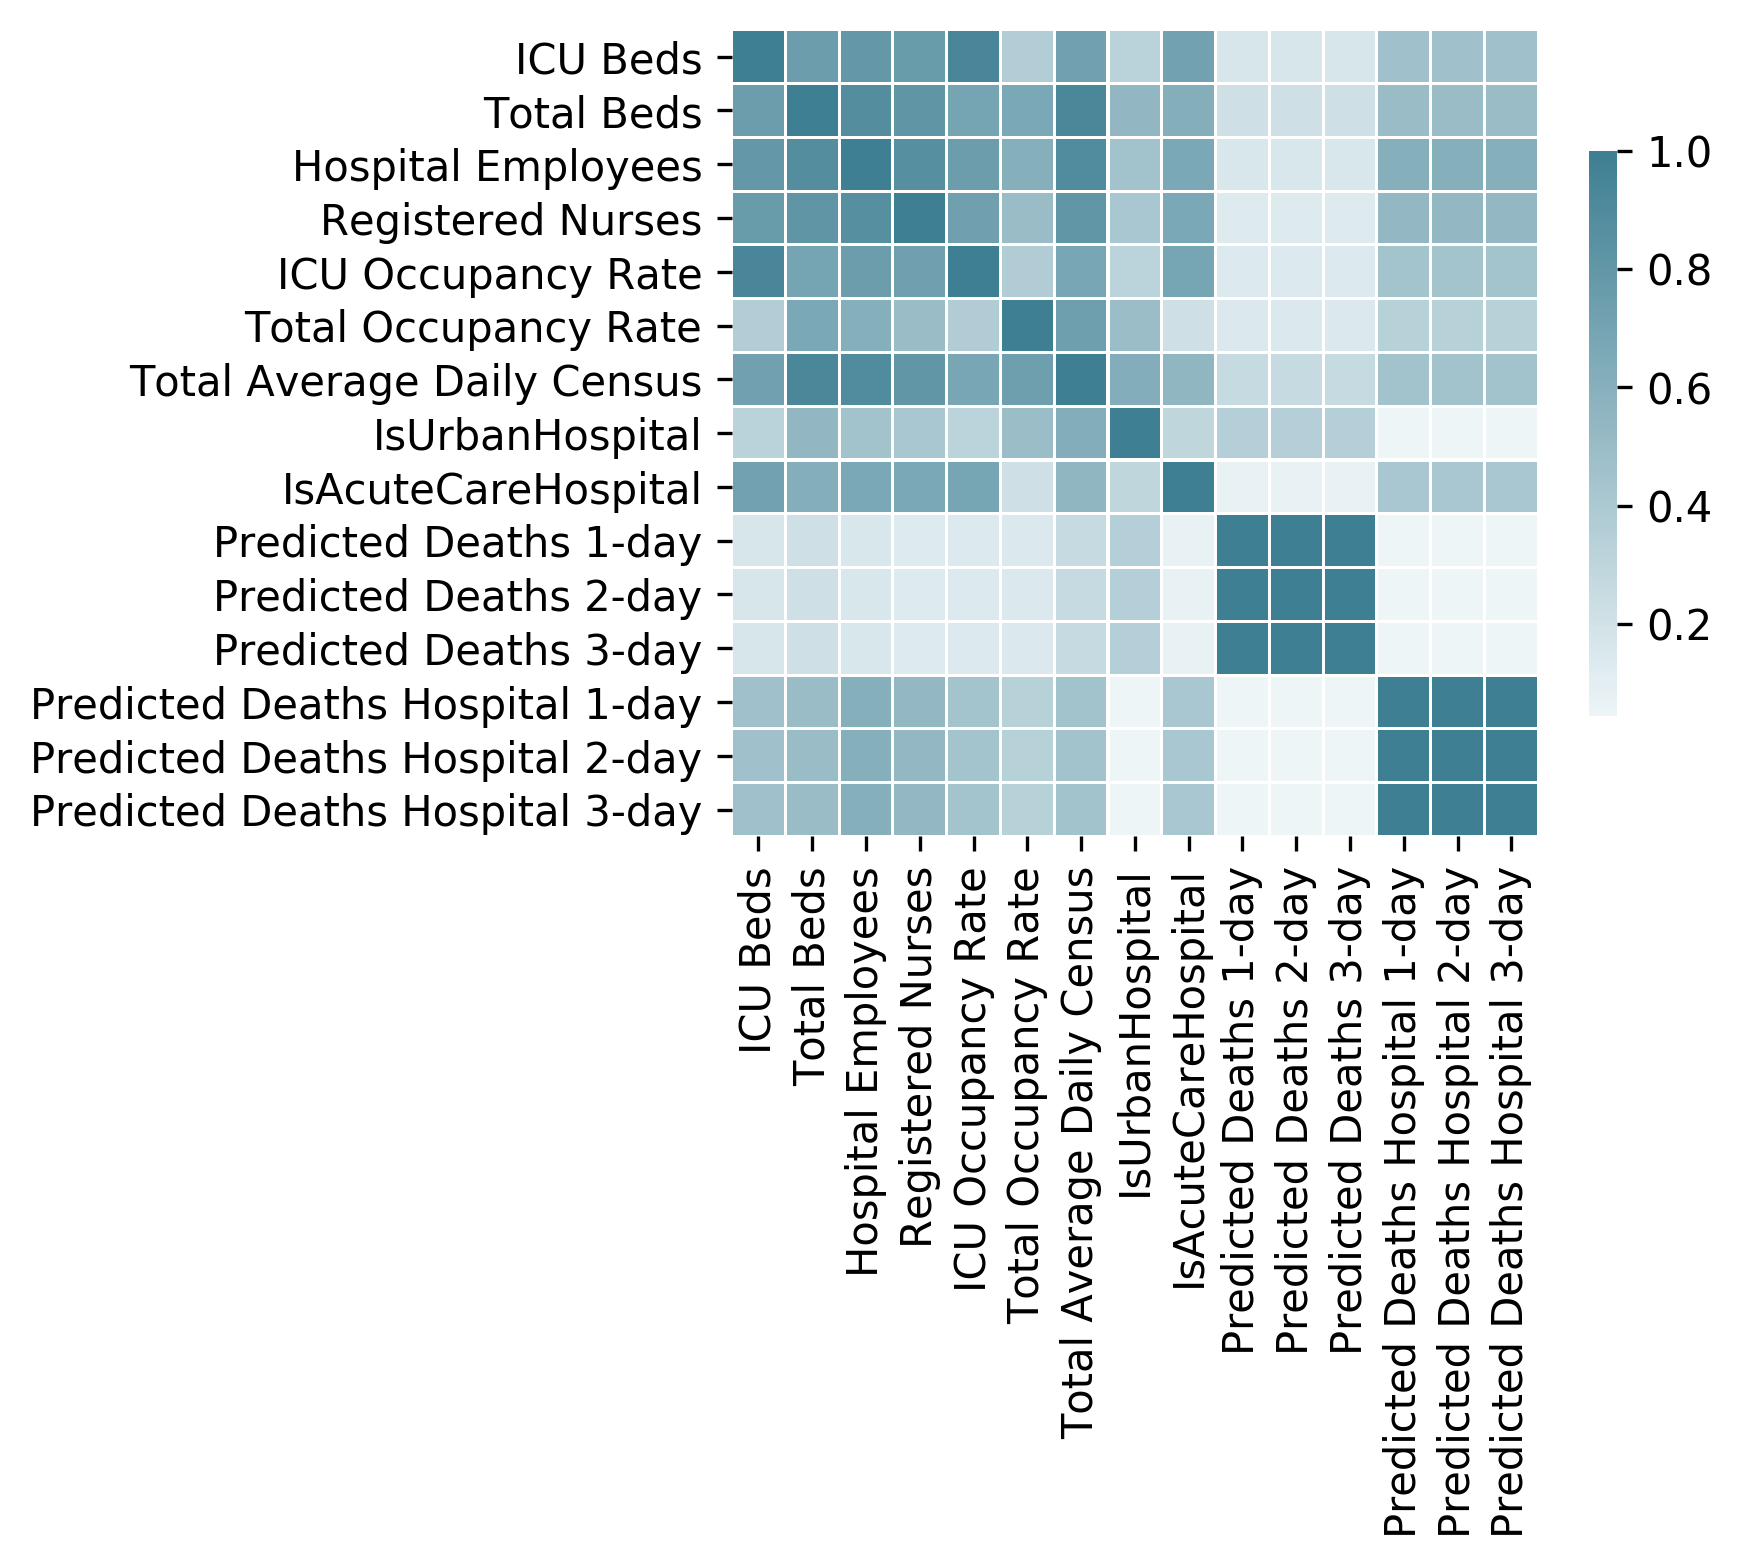

In [92]:
ks = ['ICU Beds', 'Total Beds', 
      'Hospital Employees', 'Registered Nurses',
      'ICU Occupancy Rate', 'Total Occupancy Rate',
      'Mortality national comparison', 'Total Average Daily Census',
      
#       'IsAcademicHospital', 
      'IsUrbanHospital',
      'IsAcuteCareHospital']
      
      

ks += [f'Predicted Deaths {n}-day' for n in NUM_DAYS_LIST]
ks += [f'Predicted Deaths Hospital {n}-day' for n in NUM_DAYS_LIST]

# county-level stuff
# ks += ['unacast_n_grade', Hospital Employees in County', 'tot_deaths', 'tot_cases', 'PopulationDensityperSqMile2010'] 


viz.corrplot(df[ks], SIZE=6)

**hospitals per county**

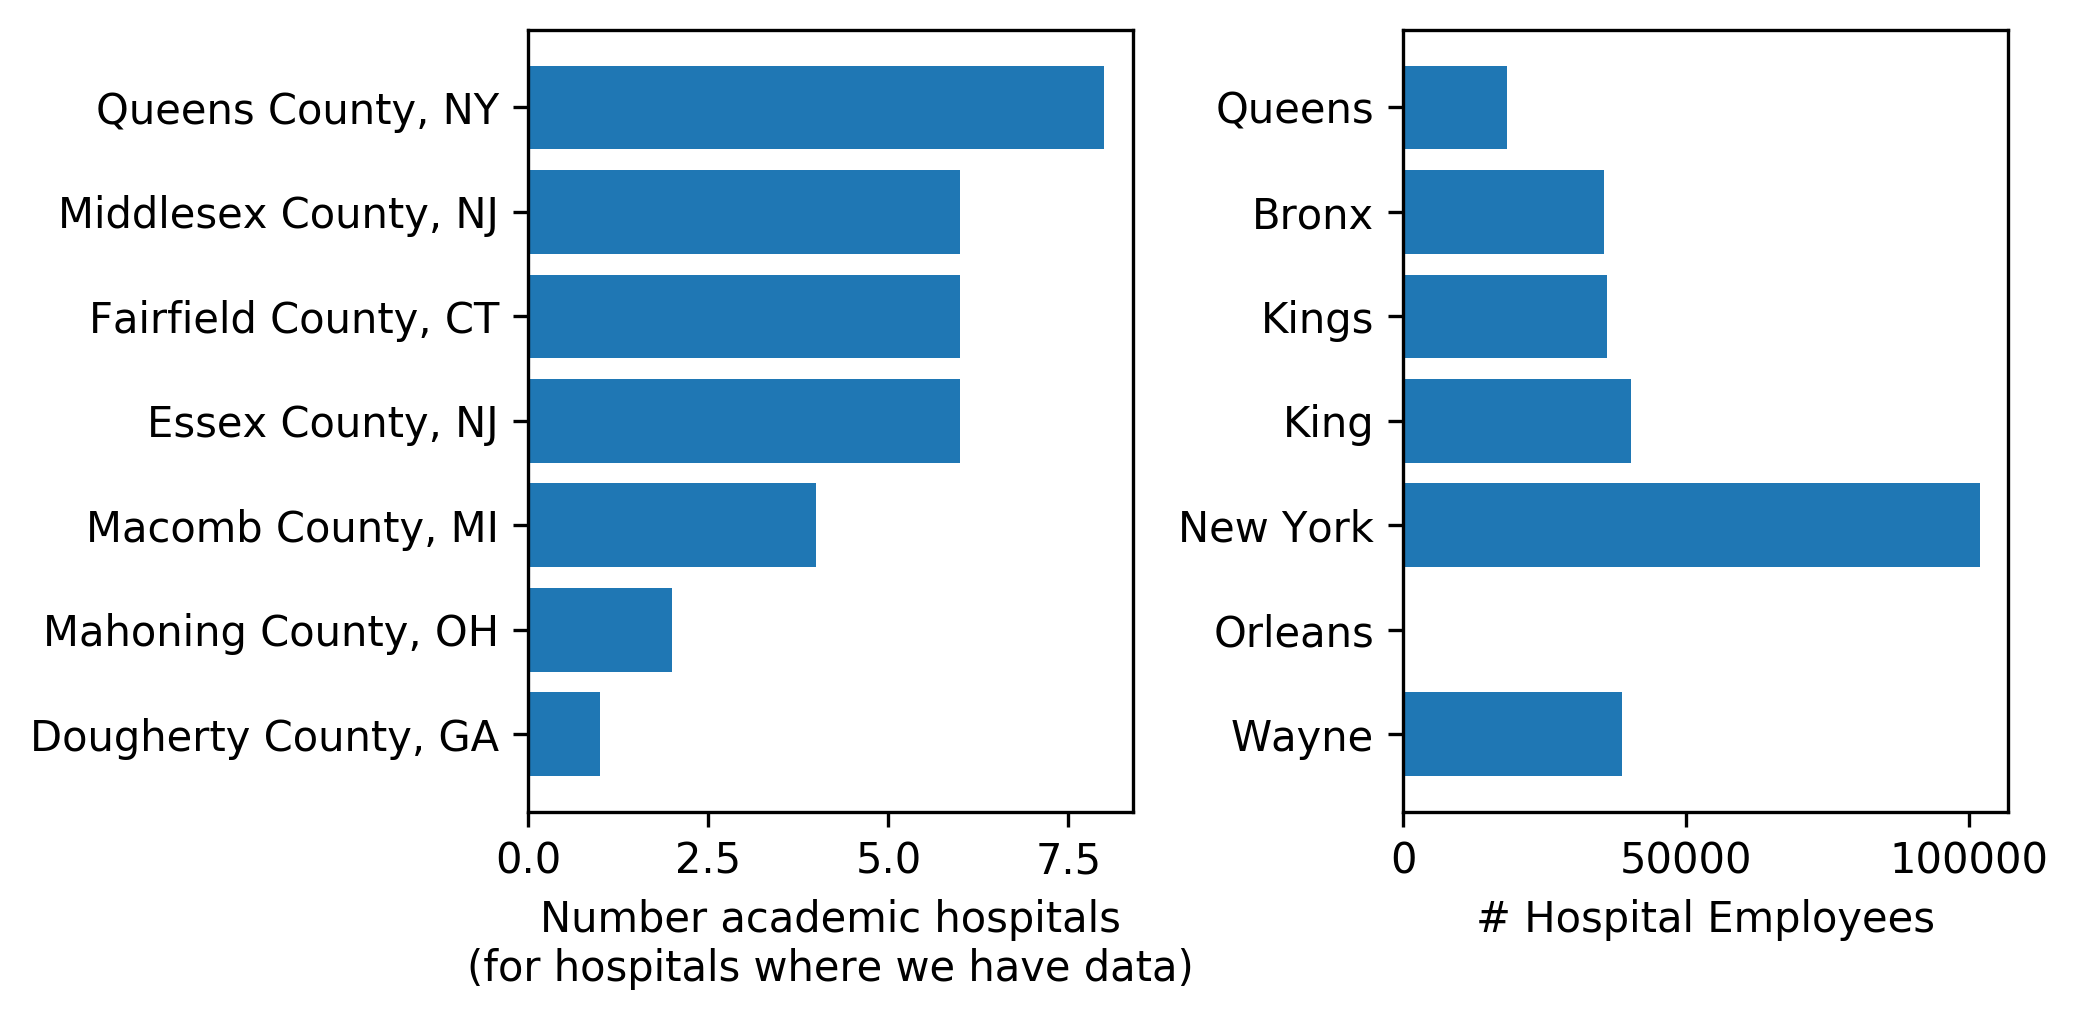

In [19]:
d = df

R, C = 1, 2
NUM_COUNTIES = 7
plt.figure(dpi=300, figsize=(7, 3.5))


plt.subplot(R, C, 1)
c = 'County Name'
county_names = d[c].unique()[:NUM_COUNTIES]
num_academic_hospitals = []
# d = df[outcome_keys + hospital_keys]
# d = d.sort_values('New Deaths', ascending=False)
for county in county_names:
    num_academic_hospitals.append(d[d[c] == county].shape[0])
plt.barh(county_names[::-1], num_academic_hospitals[::-1]) # reverse to plot top down
plt.xlabel('Number academic hospitals\n(for hospitals where we have data)')

plt.subplot(R, C, 2)
plt.barh(df_county.CountyName[:NUM_COUNTIES].values[::-1], df_county['Hospital Employees in County'][:NUM_COUNTIES][::-1]) # reverse to plot top down
plt.xlabel('# Hospital Employees')

plt.tight_layout()
plt.show()

# look at top counties

In [ ]:
county_names = d[c].unique()[:NUM_COUNTIES]
R, C = 4, 1
plt.figure(figsize=(C * 3, R * 3), dpi=200)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    cn = county_names[i]
    dc = d[d[c] == cn]
    plt.barh(dc['Hospital Name'][::-1], dc['Hospital Employees'][::-1])
    plt.title(cn)
    plt.xlabel('# Hospital Employees')
plt.tight_layout()
# plt.subplots_adjust(bottom=1)
plt.show()

# write to excel sheets

In [52]:
ks_output = ['Severity 1-day', 'Severity 2-day', 'Severity 3-day'] + \
            ['Hospital Name'] + ['CMS Certification Number', 'countyFIPS']

In [53]:
gc = pygsheets.authorize(service_file='creds.json')

#open the google spreadsheet (where 'PY to Gsheet Test' is the name of my sheet)
sheet_name = 'COVID Pandemic Severity Index'
sh = gc.open(sheet_name) # name of the hospital

# ventilator
wks = sh[0] #select a sheet
wks.update_value('A1', "Note: this sheet is read-only (automatically generated by the data and model)")
wks.set_dataframe(df[ks_output], (3, 1)) #update the first sheet with df, starting at cell B2. 